<h1 style="text-align: center; font-weight: bold;">
Model LSTM for Time Series Forecasting Temperature
</h1>


# LLibreries

In [1]:
# 📦 Gestió bàsica de dades i formats
import os
import json
import random
import warnings
from datetime import datetime
from itertools import combinations

# 📊 Tractament i visualització de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Configuració visuals
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")  # Ignorar warnings per evitar soroll

# 📈 Barra de progrés
from tqdm.notebook import tqdm

# 🧪 Preprocessament i mètriques
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error)

# 🤖 TensorFlow i Keras — Xarxes LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM
from keras import Model


# Funcions pròpies
import importlib
import lstm_functions
importlib.reload(lstm_functions)
from lstm_functions import *



2025-06-20 14:43:38.688213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 14:43:38.726339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Importacicó Dades


## Importació de dades dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [2]:
#Directori de treball

# Ruta on esta el script actual
__path__ = os.getcwd() # Si es fitxer .ipynb
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py

# Carpeta on es troben les dades
carpeta_dades = '../0_Data/Dades_T_estacions_xema_Z1'


# Directori on es guarden els models entrenats del Notebook
carpeta_model = 'models_proves_confeccio'

# Fitxers de dades
fitxer_dades_csv = 'SCM_T_Z1.csv' # Nom del fitxer CSV amb totes les dades
fitxer_dades_csv_2009_2019 = 'SCM_T_Z1_2009_2019.csv' # Nom del fitxer CSV amb les dades de 2009 a 2019
fitxer_dades_csv_2020_2024 = 'SCM_T_Z1_2020_2024.csv' # Nom del fitxer CSV amb les dades de 2020 a 2024 (final dades)

# Path complet al fitxer CSV
path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)
path_dades_2009_2019 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2009_2019)
path_dades_2020_2024 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2020_2024)


# Importar les dades 2020_2024 per LSTM ja que son recents i no tenen interrupcions ni valors nuls

df_lstm = pd.read_csv(path_dades_2020_2024)

# Convertir la columna 'data' a tipus datetime
df_lstm['data'] = pd.to_datetime(df_lstm['data'], utc=True)

# Comprovar si hi ha valors nuls
print("Valors nuls per columna en dades LSTM:")
print(df_lstm.isnull().sum())

# Mostrar el df

df_lstm


Valors nuls per columna en dades LSTM:
data     0
valor    0
dtype: int64


,data,valor
0,2020-01-01 00:00:00+00:00,1.30
1,2020-01-01 01:00:00+00:00,1.60
2,2020-01-01 02:00:00+00:00,3.20
3,2020-01-01 03:00:00+00:00,4.40
4,2020-01-01 04:00:00+00:00,4.00
...,...,...
43843,2024-12-31 19:00:00+00:00,0.10
43844,2024-12-31 20:00:00+00:00,-0.60
43845,2024-12-31 21:00:00+00:00,-0.60
43846,2024-12-31 22:00:00+00:00,-0.70


### Visualització Prèvia de les dades

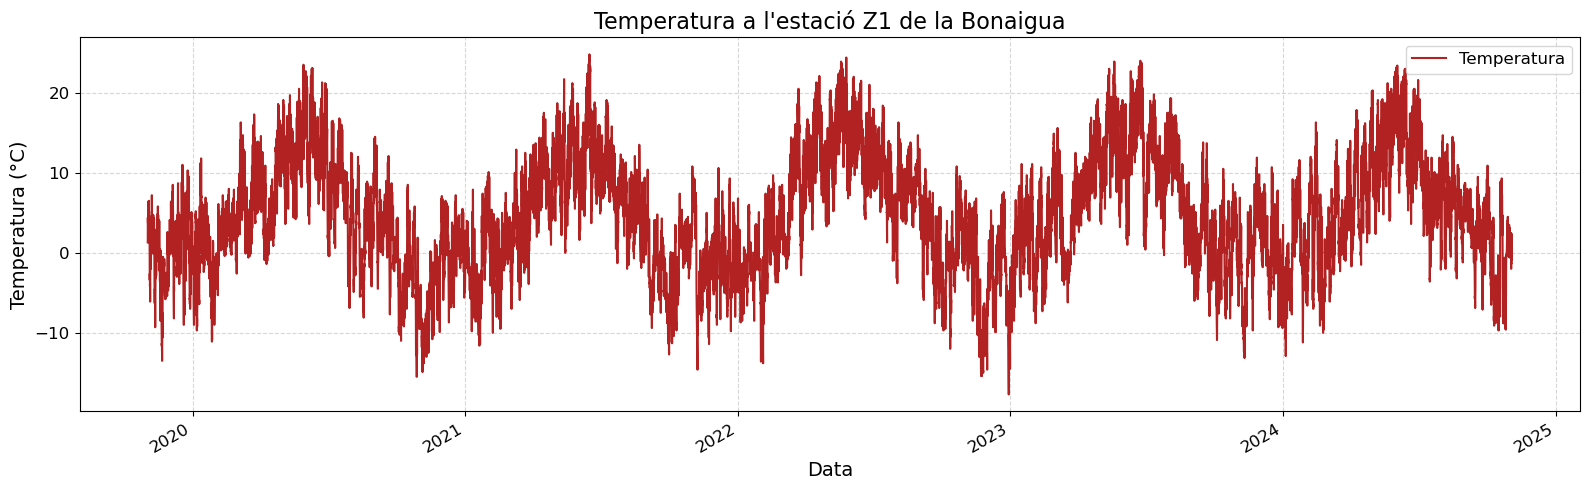

In [3]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Preparació de les dades

## Split Train , validation i test

In [4]:
# Definim les dates límit per la separació
data_max = df_lstm['data'].max()

data_limit_train = data_max - pd.DateOffset(months=6)      # Límit final del train
data_limit_val = data_max - pd.DateOffset(months=3)        # Límit final de la validació

# Separem els datasets
df_train = df_lstm[df_lstm['data'] <= data_limit_train].copy().reset_index(drop=True)
df_val = df_lstm[(df_lstm['data'] > data_limit_train) & (df_lstm['data'] <= data_limit_val)].copy().reset_index(drop=True)
df_test = df_lstm[df_lstm['data'] > data_limit_val].copy().reset_index(drop=True)


# Observem com queden les dades
print('Train dataset shape:', df_train.shape)
print('Validation dataset shape:', df_val.shape)
print('Test dataset shape:', df_test.shape)

    

Train dataset shape: (39432, 2)
Validation dataset shape: (2208, 2)
Test dataset shape: (2208, 2)


### Visualització dels conjunts de dades Train, Validation i Test

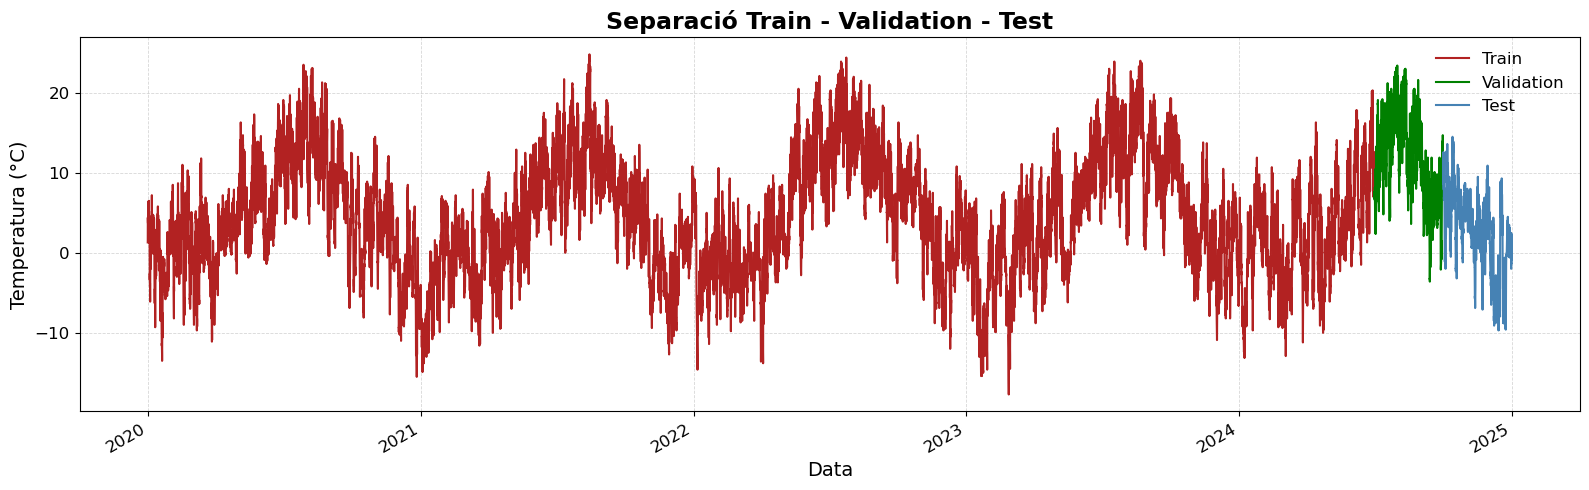

In [5]:
# Confirmem la separació amb un gràfic
plt.figure(figsize=(16, 5))
plt.plot(df_train['data'], df_train['valor'], label='Train', color='firebrick', linewidth=1.5)
plt.plot(df_val['data'], df_val['valor'], label='Validation', color='green', linewidth=1.5)
plt.plot(df_test['data'], df_test['valor'], label='Test', color='steelblue', linewidth=1.5)

plt.title('Separació Train - Validation - Test', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


## Escalat de les dades per introduir-les al model LSTM

In [5]:
# Escalem la data

scaler = MinMaxScaler()

# Escalar només sobre train i transformar val i test
df_train['valor_scaled'] = scaler.fit_transform(df_train[['valor']])
df_val['valor_scaled'] = scaler.transform(df_val[['valor']])
df_test['valor_scaled'] = scaler.transform(df_test[['valor']])


# Observem com queden les dades

print('Train dataset shape:', df_train.shape)
# display(df_train.head())

print('Validation dataset shape:', df_val.shape)
# display(df_val.head())

print('Test dataset shape:', df_test.shape)
# display(df_test.head())

Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)


# 🧠 Model LSTM — 1 output 

## Preparació de les seqüències per a l'entrenament

In [7]:
# Parametres Globals del model LSTM

# Parametrització per a la creació de seqüències 
WINDOW_SIZE = 24  # provar més tard 48, 72, 168...
N_OUTPUTS = 1  # Per predicció simple, si fos multi-step seria > 1
N_SLIDE = 1  # Desplaçament de la finestra, 1 per predicció simple
N_FEATURES = 1  # Només una variable: temperatura

In [8]:
# Creem una copia del df_test per evitar canviar el df original i afegim les dades escalades i les posteriors prediccions
df_test_pred = df_test.copy()

# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)


# Mostrem les dimensions dels conjunts de dades
print("🧾 Dimensions dels conjunts:")
print("")
print(f"  📘 Train → X: {X_train.shape} | y: {y_train.shape}")
print("---------------------------")
print(f"  📙 Validació → X: {X_val.shape} | y: {y_val.shape}")
print("---------------------------")
print(f"  📕 Test → X: {X_test.shape} | y: {y_test.shape}")

🧾 Dimensions dels conjunts:

  📘 Train → X: (39408, 24, 1) | y: (39408, 1)
---------------------------
  📙 Validació → X: (2184, 24, 1) | y: (2184, 1)
---------------------------
  📕 Test → X: (2184, 24, 1) | y: (2184, 1)


## Deficinió del Model


In [9]:
# =================================================
# Creem el directori per guardar/carregar el model 
# =================================================

nom_model = 'lstm_model.h5'
model_path = os.path.join(__path__, carpeta_model, nom_model)
os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Assegurem que el directori existeix

In [10]:

# ============================
# Definim el model LSTM
# ============================

model = Sequential([
    # 1a capa LSTM amb 64 neurones (unitats)
    # - return_sequences=True perquè tenim més capes LSTM després
    # - input_shape = (timesteps, features) → cada seqüència té X valors de temperatura (1 feature)
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),

    # Dropout per reduir overfitting (desactiva aleatòriament un 20% de les neurones durant l'entrenament)
    Dropout(0.2),

    # 2a capa LSTM (encara retorna seqüències per passar-les a la següent LSTM)
    LSTM(64, return_sequences=True),
    Dropout(0.2),

    # 3a capa LSTM (última → no retorna seqüència, només la sortida final)
    LSTM(64),
    Dropout(0.2),

    # Capa de sortida Dense:
    # - 1 neurona perquè fem una predicció escalar (una sola temperatura)
    Dense(N_OUTPUTS)
])

# Compilació del model:
# - Optimitzador Adam → ajusta els pesos de forma eficient
# - Funció de pèrdua MSE → ideal per problemes de regressió com el nostre

model.compile(
    optimizer='adam',
    loss='mse'
)


## Entrenament del Model

In [11]:
# =========================================================
# Entrenament del model multi-output
# =========================================================

# Reproduïbilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [12]:

# Callback EarlyStopping per aturar l'entrenament si no millora el val_loss
early_stop = EarlyStopping(
    monitor='val_loss',      # monitoritza la pèrdua de validació
    patience=5,              # espera 5 epochs sense millora abans d'aturar
    restore_best_weights=True  # recupera els pesos del millor epoch
)


In [13]:

# Entrenament del model:
# - epochs = 50 → nombre d'iteracions sobre tot el dataset
# - batch_size = 32 → nombre de mostres processades abans d'actualitzar els pesos
# - shuffle = False → mantenim l'ordre de les dades per més control

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32, # mida del lot per l'entrenament
    validation_data=(X_val, y_val),  # validació amb dades de validació separades
    callbacks=[early_stop],
    verbose=1,
    shuffle=False  # opcional, si vols control total de l'ordre
)

Epoch 1/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 0.0118 - val_loss: 0.0026
Epoch 2/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 3/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.0015 - val_loss: 5.5830e-04
Epoch 4/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0011 - val_loss: 8.9372e-04
Epoch 5/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 8.8240e-04 - val_loss: 5.7850e-04
Epoch 6/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 8.1599e-04 - val_loss: 5.3230e-04
Epoch 7/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 7.6508e-04 - val_loss: 4.6030e-04
Epoch 8/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - loss: 7.3259e-04 - val_loss: 5.0748e-04
Epoch 9/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 7.1064e-04 - val_loss: 4.6637e-04
Epoch 10/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - loss: 7.1595e-04 - val_loss: 4.5222e-04
Epoch 11/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,029 (972.77 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,020 (648.52 KB)

None


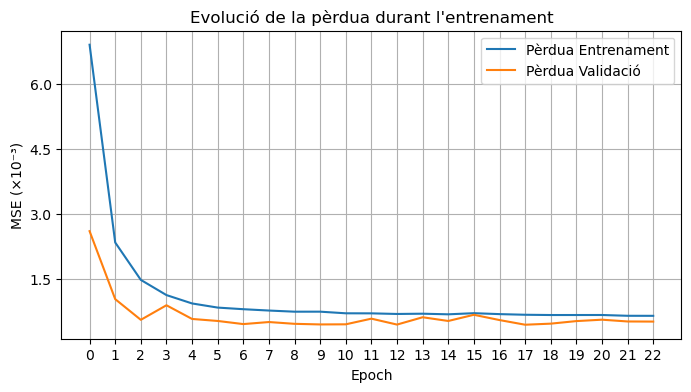

In [15]:
# ============================================
# Gràfic de la pèrdua durant l'entrenament
# ============================================

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(history.history['loss'], label='Pèrdua Entrenament')
ax.plot(history.history['val_loss'], label='Pèrdua Validació')
ax.set_title("Evolució de la pèrdua durant l'entrenament")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (×10⁻³)")

# Per ticks x cada 2 epochs
ax.set_xticks(np.arange(0, len(history.history['loss']), 1))

# Format ticks y amb 1 decimal
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))

# Força ticks a enters (però com fem decimals, pot ser opcional)
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))  # nbins controla nombre màxim ticks

ax.legend()
ax.grid(True)
plt.show()


In [16]:
# =======================================
# Guardem i carreguem el model entrenat
# =======================================

# Guarda només l'arquitectura i els pesos, sense optimitzador ni funció de pèrdua
model.save(model_path, include_optimizer=False)

## Carregar Model (Si ja tenim un entrenat)

In [17]:
# Carrega del model guardat
model = load_model(model_path)
print("Model carregat correctament des de:", model_path)
print(model.summary())

Model carregat correctament des de: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_proves/lstm_model.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

None


## Prediccions del model 

### Predicció batch

In [18]:
df_test_pred = prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='pred_batch')

In [19]:
# Avaluació de les mètriques

rmse_batch = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_batch'][WINDOW_SIZE:]))
mse_batch = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_batch'][WINDOW_SIZE:])
mae_batch = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_batch'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció batch: ")
print(f"   ▸ RMSE: {rmse_batch:.4f} °C")
print(f"   ▸ MSE: {mse_batch:.4f} °C²")
print(f"   ▸ MAE: {mae_batch:.4f} °C")

📊 Mètriques predicció batch: 
   ▸ RMSE: 0.7932 °C
   ▸ MSE: 0.6292 °C²
   ▸ MAE: 0.5331 °C


### Predicció Multi-Step Iterativa

In [20]:
df_test_pred = prediccio_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='pred_iter')

In [21]:
# Avaluació de les mètriques

rmse_iter = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_iter'][WINDOW_SIZE:]))
mse_iter = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_iter'][WINDOW_SIZE:])
mae_iter = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_iter'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció iterativa: ")
print(f"   ▸ RMSE: {rmse_iter:.4f} °C")
print(f"   ▸ MSE: {mse_iter:.4f} °C²")
print(f"   ▸ MAE: {mae_iter:.4f} °C")

📊 Mètriques predicció iterativa: 
   ▸ RMSE: 15.0439 °C
   ▸ MSE: 226.3182 °C²
   ▸ MAE: 14.2061 °C


### Predicció iterativa amb reinjecció de dades

In [22]:
df_test_pred = prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='pred_reinject')

In [23]:
# Avaluació de les mètriques

rmse_reinj = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_reinject'][WINDOW_SIZE:]))
mse_reinj = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_reinject'][WINDOW_SIZE:])
mae_reinj = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_reinject'][WINDOW_SIZE:])


print(f"📊 Mètriques predicció amb reinjecció: ")
print(f"   ▸ RMSE: {rmse_reinj:.4f} °C")
print(f"   ▸ MSE: {mse_reinj:.4f} °C²")
print(f"   ▸ MAE: {mae_reinj:.4f} °C")

📊 Mètriques predicció amb reinjecció: 
   ▸ RMSE: 1.7729 °C
   ▸ MSE: 3.1433 °C²
   ▸ MAE: 1.2162 °C


## Mètriques, errors i graficació 

In [24]:
# Taula comparativa de mètriques
metriques = pd.DataFrame({
    'Mètrica': ['RMSE', 'MSE', 'MAE'],
    'Predicció Batch': [rmse_batch, mse_batch, mae_batch],
    'Predicció Iterativa': [rmse_iter, mse_iter, mae_iter],
    'Predicció Reinjecció': [rmse_reinj, mse_reinj, mae_reinj]
})
metriques.set_index('Mètrica', inplace=True)
metriques = metriques.round(4)  # Arrodonim a 4 decimals
metriques

,Predicció Batch,Predicció Iterativa,Predicció Reinjecció
Mètrica,,,
RMSE,0.79,15.04,1.77
MSE,0.63,226.32,3.14
MAE,0.53,14.21,1.22


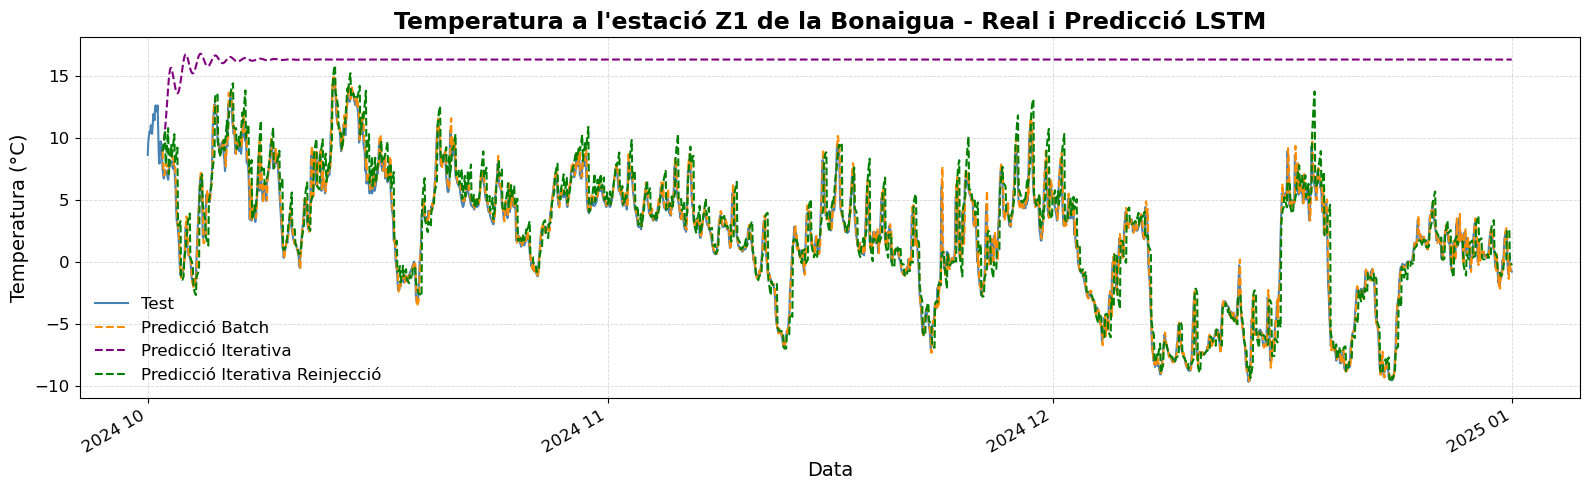

In [25]:
# Ploteig de les dades i les prediccions
plt.figure(figsize=(16, 5))  


# Defineix si es vol mostrar validació i train últims X dies
# Últims dies del train i validació

validation = False  # Si vols mostrar també la validació

dies_enrere = 0 # Dies enrere que vols mostrar del train (0 per no mostrar, >0 per mostrar els últims dies)
dies_enrere = max(dies_enrere, 0)  # Assegura que sigui >= 0

if validation == True:
    if dies_enrere > 0:

        # Ploteja últims dies de Train
        data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)
        df_train_filtrat = df_train[df_train['data'] >= data_limit]

        plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label=f'Train (últims {dies_enrere} dies)', color='firebrick', linewidth=1.5)

    # Ploteja Validation (en tots els casos on validation=True)
    plt.plot(df_val['data'], df_val['valor'],label='Validation', color='darkgreen', linewidth=1.5)


# Plot Test complet
plt.plot(df_test_pred['data'], df_test_pred['valor'], label='Test', color='steelblue', linewidth=1.5)

# Plot Predicció Bacth
plt.plot(df_test_pred['data'], df_test_pred['pred_batch'], label='Predicció Batch', color='darkorange', linewidth=1.5, linestyle='--')

# Plot Predicció iterativa
plt.plot(df_test_pred['data'], df_test_pred['pred_iter'], label='Predicció Iterativa', color='purple', linewidth=1.5, linestyle='--')

# Plot Predicció iterativa amb reinjecció
plt.plot(df_test_pred['data'], df_test_pred['pred_reinject'], label='Predicció Iterativa Reinjecció', color='green', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estació Z1 de la Bonaigua - Real i Predicció LSTM', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


# 📈 Model Multioutput LSTM


## Preparació de les seqüències per a l'entrenament

In [6]:
# Parametres Globals del model LSTM

# Parametrització per a la creació de seqüències multi-step 
WINDOW_SIZE = 24  # provar més tard 48, 72, 168...
N_OUTPUTS = 5  # Nombre de passos de predicció futura (multi-step)
N_SLIDE = N_OUTPUTS  # Desplaçament de la finestra, 1 per predicció simple, n_outputs per multi-step (si les volem clavades, sense espai i sense solapament)
N_FEATURES = 1  # Només una variable: temperatura


In [7]:
# Creem una copia de df_test per aquest model multi-step
df_test_pred_multi = df_test.copy()


# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred_multi['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)

print("🧾 Dimensions dels conjunts:")
print("")
print(f"  📘 Train → X: {X_train.shape} | y: {y_train.shape}")
print("---------------------------")
print(f"  📙 Validació → X: {X_val.shape} | y: {y_val.shape}")
print("---------------------------")
print(f"  📕 Test → X: {X_test.shape} | y: {y_test.shape}")


🧾 Dimensions dels conjunts:

  📘 Train → X: (7881, 24, 1) | y: (7881, 5)
---------------------------
  📙 Validació → X: (436, 24, 1) | y: (436, 5)
---------------------------
  📕 Test → X: (436, 24, 1) | y: (436, 5)


## Definició del Model Multioutput

In [9]:
# ========================================================================
# Creem el directori per guardar/carregar el model multi-output
# ========================================================================

nom_model_multi = 'lstm_model_multioutput.h5'
carpeta_model_multi = carpeta_model
model_multi_path = os.path.join(__path__, carpeta_model_multi, nom_model_multi)
os.makedirs(os.path.dirname(model_multi_path), exist_ok=True)

In [29]:
# ==================================================
# Definim el model LSTM multi-output
# ==================================================

model_multi = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(N_OUTPUTS)  # Capa final amb tantes neurones com outputs vulguem
])

model_multi.compile(
    optimizer='adam',
    loss='mse'
)

## Entrenament del Model Multioutput

In [30]:
# =========================================================
# Entrenament del model multi-output
# =========================================================

# Reproductibilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [31]:

# Callback per early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [32]:

# Entrenament del model:
# - epochs = 50 → nombre d'iteracions sobre tot el dataset
# - batch_size = 32 → nombre de mostres processades abans d'actualitzar els pesos
# - shuffle = False → mantenim l'ordre de les dades per més control

history_multi = model_multi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0279 - val_loss: 0.0064
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0083 - val_loss: 0.0061
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 8/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 9/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 10/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 11/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 12/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 

In [33]:
print(model_multi.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,809 (975.82 KB)

 Trainable params: 83,269 (325.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,540 (650.55 KB)

None


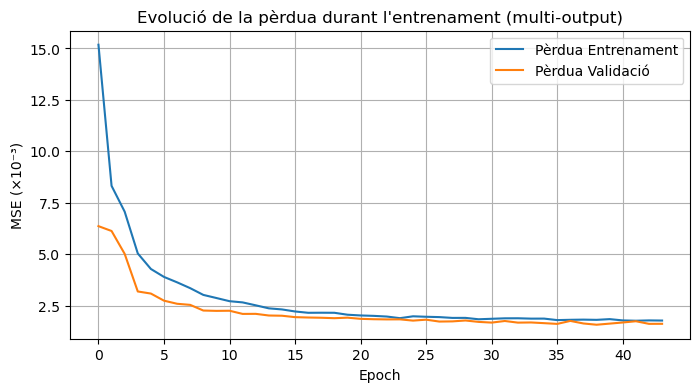

In [34]:
# ============================================
# Gràfic de la pèrdua durant l'entrenament
# ============================================

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history_multi.history['loss'], label='Pèrdua Entrenament')
ax.plot(history_multi.history['val_loss'], label='Pèrdua Validació')
ax.set_title("Evolució de la pèrdua durant l'entrenament (multi-output)")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (×10⁻³)")
ax.set_xticks(np.arange(0, len(history_multi.history['loss']), 5))
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))
ax.legend()
ax.grid(True)
plt.show()


In [35]:
# =======================================
# Guardem i carreguem el model entrenat
# =======================================

# Guarda només l'arquitectura i els pesos, sense optimitzador ni funció de pèrdua
model_multi.save(model_multi_path, include_optimizer=False)

## Carregar Model Multi (Si ja tenim un entrenat)

In [10]:
# Carreguem el model
model_multi = load_model(model_multi_path)
print("Model carregat correctament des de:", model_multi_path)
print(model_multi.summary())


Model carregat correctament des de: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_proves_confeccio/lstm_model_multioutput.h5


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,269 (325.27 KB)

 Trainable params: 83,269 (325.27 KB)

 Non-trainable params: 0 (0.00 B)

None


## Prediccions del model Multioutput

### Predicció batch multioutput

In [11]:
# Prova --> Resetejar el df_test_multi
df_test_pred_multi = df_test.copy()

df_test_pred_multi = prediccio_batch_multi(model_multi, X_test, df_test_pred_multi, scaler=scaler, window_size=WINDOW_SIZE, n_outputs=N_OUTPUTS, nom_columna='pred_batch')

In [17]:
df_test_pred_multi 

,data,valor,valor_scaled,pred_batch
0,2024-10-01 00:00:00+00:00,8.60,0.62,NaN
1,2024-10-01 01:00:00+00:00,9.70,0.64,NaN
2,2024-10-01 02:00:00+00:00,10.20,0.66,NaN
3,2024-10-01 03:00:00+00:00,10.50,0.66,NaN
4,2024-10-01 04:00:00+00:00,10.40,0.66,NaN
...,...,...,...,...
2203,2024-12-31 19:00:00+00:00,0.10,0.42,2.44
2204,2024-12-31 20:00:00+00:00,-0.60,0.40,NaN
2205,2024-12-31 21:00:00+00:00,-0.60,0.40,NaN
2206,2024-12-31 22:00:00+00:00,-0.70,0.40,NaN


In [12]:
# Metriques de la predicció multi-output
rmse_batch_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_batch_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_batch_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"📊 Mètriques predicció multi-output: ")
print(f"   ▸ RMSE: {rmse_batch_multi:.4f} °C")
print(f"   ▸ MSE: {mse_batch_multi:.4f} °C²")
print(f"   ▸ MAE: {mae_batch_multi:.4f} °C")

📊 Mètriques predicció multi-output: 
   ▸ RMSE: 1.6669 °C
   ▸ MSE: 2.7786 °C²
   ▸ MAE: 1.2692 °C


### Predicció multi-step iterativa multioutput

In [39]:
df_test_pred_multi = prediccio_step_iterativa_multi(model_multi, X_test, df_test_pred_multi, scaler, nom_columna='pred_iter')

In [40]:
# Metriques de la predicció multi-output
rmse_iter_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_iter_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_iter_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"📊 Mètriques predicció multi-output iterativa: ")
print(f"   ▸ RMSE: {rmse_iter_multi:.4f} °C")
print(f"   ▸ MSE: {mse_iter_multi:.4f} °C²")
print(f"   ▸ MAE: {mae_iter_multi:.4f} °C")

📊 Mètriques predicció multi-output iterativa: 
   ▸ RMSE: 10.6166 °C
   ▸ MSE: 112.7113 °C²
   ▸ MAE: 9.4596 °C


### Predicció amb reinjecció de dades real multioutput

In [46]:
df_test_pred_multi = prediccio_iterativa_reinjection_multi(model_multi, X_test, df_test_pred_multi, scaler, reinjeccio=5, nom_columna='pred_reinject')

In [47]:
# Metriques de la predicció multi-output
rmse_reinj_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_reinj_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_reinj_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"📊 Mètriques predicció multi-output reinject:")
print(f"   ▸ RMSE: {rmse_reinj_multi:.4f} °C")
print(f"   ▸ MSE: {mse_reinj_multi:.4f} °C²")
print(f"   ▸ MAE: {mae_reinj_multi:.4f} °C")

📊 Mètriques predicció multi-output reinject:
   ▸ RMSE: 4.0428 °C
   ▸ MSE: 16.3438 °C²
   ▸ MAE: 3.0943 °C


## Metriques, errors i graficació multioutput

In [16]:
# Taula comparativa de mètriques
metriques_multi = pd.DataFrame({
    'Mètrica': ['RMSE', 'MSE', 'MAE'],
    'Predicció Batch': [rmse_batch_multi, mse_batch_multi, mae_batch_multi],
    # 'Predicció Iterativa': [rmse_iter_multi, mse_iter_multi, mae_iter_multi],
    # 'Predicció Reinjecció': [rmse_reinj_multi, mse_reinj_multi, mae_reinj_multi]
})
metriques_multi.set_index('Mètrica', inplace=True)
metriques_multi = metriques_multi.round(4)  # Arrodonim a 4 decimals
metriques_multi

,Predicció Batch
Mètrica,
RMSE,1.67
MSE,2.78
MAE,1.27


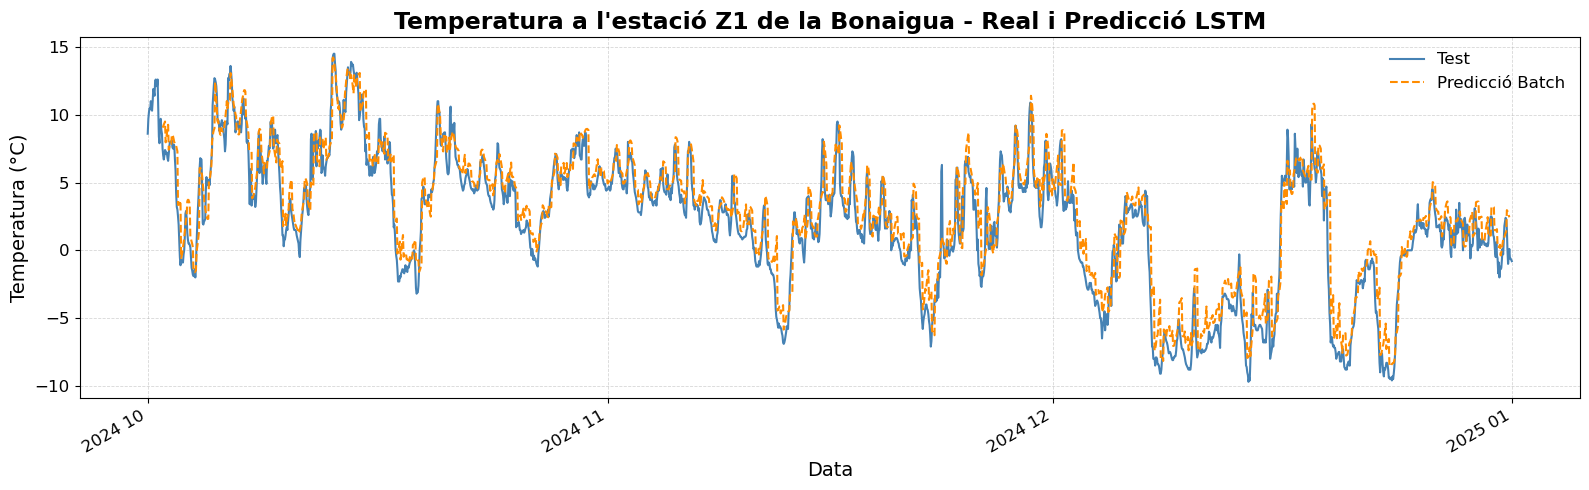

In [15]:
# Ploteig de les dades i les prediccions
plt.figure(figsize=(16, 5))  


# Defineix si es vol mostrar validació i train últims X dies
# Últims dies del train i validació

validation = False  # Si vols mostrar també la validació

dies_enrere = 0 # Dies enrere que vols mostrar del train (0 per no mostrar, >0 per mostrar els últims dies)
dies_enrere = max(dies_enrere, 0)  # Assegura que sigui >= 0

if validation == True:
    if dies_enrere > 0:

        # Ploteja últims dies de Train
        data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)
        df_train_filtrat = df_train[df_train['data'] >= data_limit]

        plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label=f'Train (últims {dies_enrere} dies)', color='firebrick', linewidth=1.5)

    # Ploteja Validation (en tots els casos on validation=True)
    plt.plot(df_val['data'], df_val['valor'],label='Validation', color='darkgreen', linewidth=1.5)


# Plot Test complet
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['valor'], label='Test', color='steelblue', linewidth=1.5)

# Plot Predicció Bacth
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_batch'], label='Predicció Batch', color='darkorange', linewidth=1.5, linestyle='--')

# Plot Predicció iterativa
# plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_iter'], label='Predicció Iterativa', color='purple', linewidth=1.5, linestyle='--')

# Plot Predicció iterativa amb reinjecció
# plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_reinject'], label='Predicció Iterativa Reinjecció', color='darkgreen', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estació Z1 de la Bonaigua - Real i Predicció LSTM', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()
